In [1]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick 
from mpl_toolkits.mplot3d import axes3d

# 拡散日射を微小要素に分割するモジュール

## 1. Functions  

### 1.1. 天空日射

開口部が垂直窓の場合に、天空日射量に対する天空上の任意の微小要素からの天空日射量の割合を計算する。

### 入力値  

$ N_{d,\Phi} $：天空の緯度方向の分割数  
$ N_{d,L} $：天空の経度方向の分割数  
$ l $：天空の緯度方向の$l$番目の分割要素  
$ m $：天空の経度方向の$m$番目の分割要素

### 出力値

$ F_{d,l,m} $ ：天空日射量に対する天空上の微小要素からの天空日射量の割合  
$ h_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する高度角 (°)  
$ A_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する方位角 (°)  
$ \phi_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する入射角 (°)  

### 計算方法

#### データ構造と値の範囲

$ N_{d,\Phi} $・$ N_{d,L} $の組み合わせを1つの変数（タプル）で表し"dd_input"とする。  
$ F_{d,l,m} $は0.0以上1.0以下の値をとる。  
$ h_{d,l,m} $は0°以上、90°以下の値をとる（地平：0°、天頂：90°）。  
$ A_{d,l,m} $は-90°以上、90°以下の値をとる（東：-90°、南：0°、西：90°）。  
$ \phi_{d,l,m} $は0°以上、90°以下の値をとる（法線方向：0°、接線方向：90°）。

In [2]:
#class dd_input(namedtuple('dd_input', 'dd_Nlat dd_Nlon dd_l dd_m')):
#    __slots__ = () 

#dd_Nlat：天空の緯度方向の分割数
#dd_Nlon：天空の経度方向の分割数
#dd_l：天空の緯度方向のi番目の分割要素
#dd_m：天空の経度方向のj番目の分割要素

In [3]:
class dd_input():
    def __init__( self, Nlat, Nlon, l, m ):
        self.Nlat = Nlat
        self.Nlon = Nlon
        self.l = l
        self.m = m

#Nlat：天空の緯度方向の分割数
#Nlon：天空の経度方向の分割数
#l：天空の緯度方向のi番目の分割要素
#m：天空の経度方向のj番目の分割要素

#### 微小要素からの天空日射の割合の計算

開口部が垂直窓の場合に、天空日射量に対する天空上の微小要素からの天空日射量の割合$F_{d,l,m}$の計算方法を以下に示す。

$ \begin{align}F_{d,l,m} = \frac{2 ･ \omega_{d,l,m} ･ \cos \phi_{d,l,m}}{\pi}\end{align}$ ･･･････････････････････････ (3.2.1-a)  

$ \begin{align}\omega_{d,l,m} = \cos h_{d,l,m} ･ \frac{\pi}{2 ･ N_{d,lat}} ･ \frac{\pi}{N_{d,lon}}\end{align}$ ････････････････････ (3.2.1-b)  

$ \begin{align}\cos\phi_{d,l,m} = \cos h_{d,l,m} ･ \cos A_{d,l,m}\end{align}$ ････････････････････････ (3.2.1-c)  

$ \begin{align}h_{d,l,m} = \frac{90 ･ (2 ･ l +1)}{2 ･ N_{d,lat}}\end{align}$ ････････････････････････････････ (3.2.1-d)  

$ \begin{align}A_{d,l,m} = \frac{180 ･ (2 ･ m +1)}{2 ･ N_{d,lon}} - 90\end{align}$ ･･････････････････････････ (3.2.1-e)  

ここで、 

$ \omega_{d,l,m} $：天空日射の微小要素$l,m$における開口面に対する立体角 [sr]  
$ l $：カウンター（0～$N_{d,lat}$ - 1）  
$ m $：カウンター（0～$N_{d,lon}$ - 1）  

である。  

In [4]:
#微小要素からの天空日射の割合の計算
#割合、高度角、方位角、入射角
def division_diffuse_ratio(L):
    
    #r_dd_h = 90. * (2. * L.dd_l + 1) / (2. * L.dd_Nlat) #高度角
    r_dd_h = 90. * (2. * L.l + 1) / (2. * L.Nlat) #高度角
    #r_dd_A = 180. * (2. * L.dd_m + 1) / (2. * L.dd_Nlon) - 90. #方位角
    r_dd_A = 180. * (2. * L.m + 1) / (2. * L.Nlon) - 90. #方位角
    r_dd_phi = math.degrees(math.acos(abs(math.cos(math.radians(r_dd_h)) * math.cos(math.radians(r_dd_A))))) #入射角
    #dd_omega = math.cos(math.radians(r_dd_h)) * math.pi ** 2. / (2. * L.dd_Nlat * L.dd_Nlon)
    dd_omega = math.cos(math.radians(r_dd_h)) * math.pi ** 2. / (2. * L.Nlat * L.Nlon)
    r_dd_f = 2 * dd_omega * math.cos(math.radians(r_dd_phi)) / math.pi #割合
    
    return r_dd_f, r_dd_h, r_dd_A, r_dd_phi

#### Example

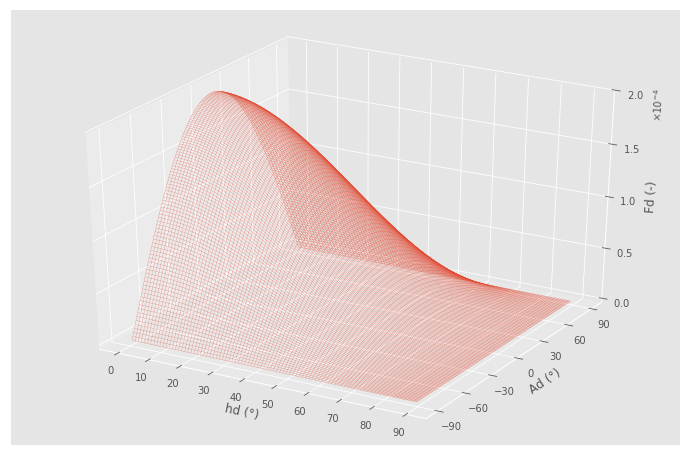

In [5]:
if __name__ == '__main__':

    Nd_lat = 90
    Nd_lon = 180

    dd_F = np.empty((Nd_lat, Nd_lon))
    dd_h = np.empty((Nd_lat, Nd_lon))
    dd_A = np.empty((Nd_lat, Nd_lon))
    dd_phi = np.empty((Nd_lat, Nd_lon))

    for l in range(0, Nd_lat):
        for m in range(0, Nd_lon):
            dd_in =dd_input(Nd_lat, Nd_lon, l, m)
            dd_F[l][m] = division_diffuse_ratio(dd_in)[0]   #割合
            dd_h[l][m] = division_diffuse_ratio(dd_in)[1]   #高度角
            dd_A[l][m] = division_diffuse_ratio(dd_in)[2]   #方位角
            dd_phi[l][m] = division_diffuse_ratio(dd_in)[3] #入射角

    #np.savetxt('out_hd.csv', dd_h, fmt='%.10f', delimiter=',')
    #np.savetxt('out_Ad.csv', dd_A, fmt='%.10f', delimiter=',')
    #np.savetxt('out_phid.csv', dd_phi, fmt='%.10f', delimiter=',')
    #np.savetxt('out_Fd.csv', dd_F, fmt='%.10f', delimiter=',')

    #グラフの描画
    fig = plt.figure(figsize=(12,8))
    plt.style.use('ggplot')

    ax = fig.gca(projection='3d')
    ax.plot_wireframe(dd_h[0:Nd_lat][0:Nd_lon], dd_A[0:Nd_lat][0:Nd_lon], dd_F[0:Nd_lat][0:Nd_lon], rstride=1, cstride=1, linewidth=0.2)
    ax.set_xticks([10 * i for i in range(10)])
    ax.set_yticks([30 * i - 90 for i in range(7)])
    ax.set_zticks([5e-5 * i for i in range(5)])

    ax.set_xlabel('hd (°)', fontsize = 12)
    ax.set_ylabel('Ad (°)', fontsize = 12)
    ax.set_zlabel('Fd (-)', fontsize = 12)

    ax.zaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    ax.ticklabel_format(style='sci',axis='z',scilimits=(0,0)) 

    plt.show()

### 1.2. 地表面反射日射

開口部が垂直窓の場合に、地表面反射日射量に対する地表面の任意の微小要素からの地表面反射日射量の割合を計算する。

### 入力値  

$ N_{r,\Phi} $：地表面の緯度方向の分割数  
$ N_{r,L} $：地表面の経度方向の分割数  
$ l $：地表面の緯度方向の$l$番目の分割要素  
$ m $：地表面の経度方向の$m$番目の分割要素

### 出力値

$ F_{r,l,m} $ ：地表面反射日射量に対する地表面上の微小要素からの地表面反射日射量の割合  
$ h_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する高度角 (°)  
$ A_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する方位角 (°)  
$ \phi_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する入射角 (°)  

### 計算方法

#### データ構造と値の範囲

$ N_{r,\Phi} $・$ N_{r,L} $の組み合わせを1つの変数（タプル）で表し"dr_input"とする。  
$ F_{r,l,m} $は0.0以上1.0以下の値をとる。  
$ h_{r,l,m} $は-90°以上、0°以下の値をとる（地平：0°、天頂：-90°）。  
$ A_{r,l,m} $は-90°以上、90°以下の値をとる（東：-90°、南：0°、西：90°）。  
$ \phi_{r,l,m} $は0°以上、90°以下の値をとる（法線方向：0°、接線方向：90°）。

In [6]:
#class dr_input(namedtuple('dr_input', 'dr_Nlat dr_Nlon dr_l dr_m')):
#    __slots__ = () 
    
#dr_Nlat：地表面の緯度方向の分割数
#dr_Nlon：地表面の経度方向の分割数
#dr_l：地表面の緯度方向のi番目の分割要素
#dr_m：地表面の経度方向のj番目の分割要素

In [7]:
class dr_input():
    def __init__( self, Nlat, Nlon, l, m ):
        self.Nlat = Nlat
        self.Nlon = Nlon
        self.l = l
        self.m = m

#Nlat：地表面の緯度方向の分割数
#Nlon：地表面の経度方向の分割数
#l：地表面の緯度方向のi番目の分割要素
#m：地表面の経度方向のj番目の分割要素

#### 微小要素からの地表面反射日射の割合の計算

開口部が垂直窓の場合に、地表面反射日射量に対する地表面上の微小要素からの地表面反射日射量の割合$F_{r,l,m}$の計算方法を以下に示す。

$ \begin{align}F_{r,l,m} = \frac{2 ･ \omega_{r,l,m} ･ \cos \phi_{r,l,m}}{\pi}\end{align}$ ･･･････････････････････････ (3.2.2-a)  

$ \begin{align}\omega_{r,l,m} = \cos h_{r,l,m} ･ \frac{\pi}{2 ･ N_{r,lat}} ･ \frac{\pi}{N_{r,lon}}\end{align}$ ････････････････････ (3.2.2-b)  

$ \begin{align}\cos\phi_{r,l,m} = \cos h_{r,l,m} ･ \cos A_{r,l,m}\end{align}$ ････････････････････････ (3.2.2-c)  

$ \begin{align}h_{r,l,m} = \frac{90 ･ (2 ･ l +1)}{2 ･ N_{r,lat}} - 90\end{align}$ ･･･････････････････････････ (3.2.2-d)  

$ \begin{align}A_{r,l,m} = \frac{180 ･ (2 ･ m +1)}{2 ･ N_{r,lon}} - 90\end{align}$ ･･････････････････････････ (3.2.2-e)  

ここで、 

$ \omega_{r,l,m} $：地表面反射日射の微小要素$l,m$における開口面に対する立体角 [sr]  
$ l $：カウンター（0～$N_{r,lat}$ - 1）  
$ m $：カウンター（0～$N_{r,lon}$ - 1）  

である。  

In [8]:
#微小要素からの地表面反射日射の割合の計算
#割合、高度角、方位角、入射角
def division_reflect_ratio(L):

    #r_dr_h = 90. * (2. * L.dr_l + 1) / (2. * L.dr_Nlat) - 90.  #高度角
    r_dr_h = 90. * (2. * L.l + 1) / (2. * L.Nlat) - 90.  #高度角
    #r_dr_A = 180. * (2. * L.dr_m + 1) / (2. * L.dr_Nlon) - 90. #方位角
    r_dr_A = 180. * (2. * L.m + 1) / (2. * L.Nlon) - 90. #方位角
    r_dr_phi = math.degrees(math.acos(abs(math.cos(math.radians(r_dr_h)) * math.cos(math.radians(r_dr_A))))) #入射角
    #dr_omega = math.cos(math.radians(r_dr_h)) * math.pi ** 2. / (2. * L.dr_Nlat * L.dr_Nlon)
    dr_omega = math.cos(math.radians(r_dr_h)) * math.pi ** 2. / (2. * L.Nlat * L.Nlon)
    r_dr_f = 2 * dr_omega * math.cos(math.radians(r_dr_phi)) / math.pi #割合
    
    return r_dr_f, r_dr_h, r_dr_A, r_dr_phi

#### Example

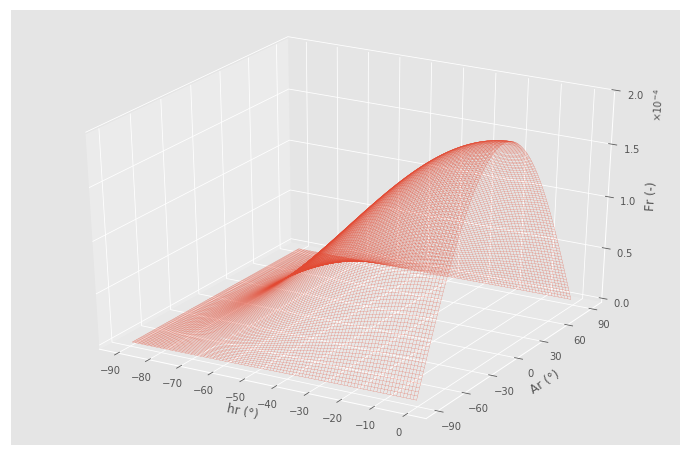

In [9]:
if __name__ == '__main__':

    Nr_lat = 90
    Nr_lon = 180

    dr_F = np.empty((Nr_lat, Nr_lon))
    dr_h = np.empty((Nr_lat, Nr_lon))
    dr_A = np.empty((Nr_lat, Nr_lon))
    dr_phi = np.empty((Nr_lat, Nr_lon))

    for l in range(0, Nr_lat):
        for m in range(0, Nr_lon):
            dr_in =dr_input(Nr_lat, Nr_lon, l ,m)
            dr_F[l][m] = division_reflect_ratio(dr_in)[0]   #割合
            dr_h[l][m] = division_reflect_ratio(dr_in)[1]   #高度角
            dr_A[l][m] = division_reflect_ratio(dr_in)[2]   #方位角
            dr_phi[l][m] = division_reflect_ratio(dr_in)[3] #入射角

    #np.savetxt('out_hr.csv', dr_h, fmt='%.10f', delimiter=',')
    #np.savetxt('out_Ar.csv', dr_A, fmt='%.10f', delimiter=',')
    #np.savetxt('out_phir.csv', dr_phi, fmt='%.10f', delimiter=',')
    #np.savetxt('out_Fr.csv', dr_F, fmt='%.10f', delimiter=',')

    #グラフの描画
    fig = plt.figure(figsize=(12,8))
    plt.style.use('ggplot')

    ax = fig.gca(projection='3d')
    ax.plot_wireframe(dr_h[0:Nr_lat][0:Nr_lon], dr_A[0:Nr_lat][0:Nr_lon], dr_F[0:Nr_lat][0:Nr_lon], rstride=1, cstride=1, linewidth=0.2)
    ax.set_xticks([10 * i - 90 for i in range(10)])
    ax.set_yticks([30 * i - 90 for i in range(7)])
    ax.set_zticks([5e-5 * i for i in range(5)])

    ax.set_xlabel('hr (°)', fontsize = 12)
    ax.set_ylabel('Ar (°)', fontsize = 12)
    ax.set_zlabel('Fr (-)', fontsize = 12)

    ax.zaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True)) 
    ax.ticklabel_format(style='sci',axis='z',scilimits=(0,0)) 

    plt.show()